In [2]:
import numpy as np  
import scipy.constants as const 
import matplotlib.pyplot as plt 
import uncertainties as unc 
%matplotlib inline

In [3]:
peaks = np.array([9.1, 25, 111.77, 157.12, 201.94])
delta_peaks = np.array([4, 8, 10.5, 14, 16.1])
energies =  np.array([0.03, 0.081, 0.356, 0.511, 0.662])

In [4]:
channel = np.array([193.61, 154.5, 128.04, 102.74, 82.12, 71.7, 61.9])
angle = np.array([20, 40, 60, 80, 100, 120, 140])
delta_peaks2 = np.array([25.69, 32.73, 27.3, 18.8, 13.7, 10.6, 9.7])

In [5]:
thickness  = np.array([0, 0.5, 3, 5, 7, 9.5, 11.5, 14.5, 15.5, 17, 18.5, 20])
counts = np.array([425968, 419850, 350531, 293762, 207537, 187661, 155524, 124045, 105649, 95631, 83636, 69050])

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 5
    # variables        = 2
    chi-square         = 7.6275e-05
    reduced chi-square = 2.5425e-05
    Akaike info crit   = -51.4530267
    Bayesian info crit = -52.2341509
    R-squared          = 0.99974200
[[Variables]]
    slope:      0.00326795 +/- 3.0310e-05 (0.93%) (init = 0.003267953)
    intercept: -0.00201753 +/- 0.00380180 (188.44%) (init = -0.002017535)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8051


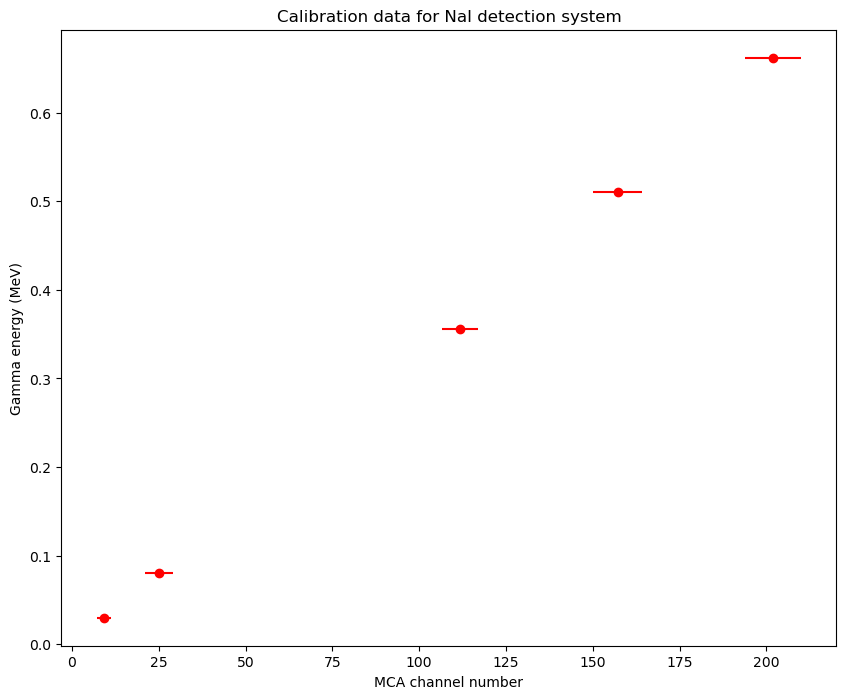

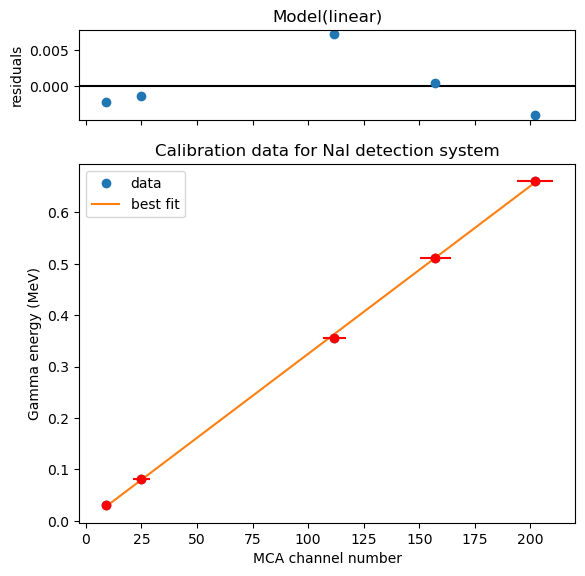

In [6]:
from lmfit.models import LinearModel

plt.figure(figsize=(10,8))
plt.xlabel('MCA channel number')
plt.ylabel('Gamma energy (MeV)')
plt.title('Calibration data for NaI detection system')
plt.errorbar(peaks,energies,xerr=delta_peaks/2,fmt='ro');


line = LinearModel()
param_guess = line.guess(energies, x=peaks)
line_fit = line.fit(energies, param_guess, x=peaks)
print(line_fit.fit_report())
line_fit.plot();

plt.xlabel('MCA channel number')
plt.ylabel('Gamma energy (MeV)')
plt.title('Calibration data for NaI detection system')
plt.errorbar(peaks,energies,xerr=delta_peaks/2,fmt='ro');


In [7]:
calibration_slope = line_fit.params['slope'].value
calibration_intercept = line_fit.params['intercept'].value

In [8]:
from scipy.constants import c, electron_mass
unit_conversion = 6.242e12

def angle_expected_channel(specific_channel, energy,angle):
    energy = specific_channel*calibration_slope+calibration_intercept
    alpha = (energy)/(electron_mass*c**2*unit_conversion)
    expected_energy = energy/(1+(alpha)*(1-np.cos(angle*np.pi/180)))
    expected_channel = (expected_energy-calibration_intercept)/calibration_slope
    return expected_channel

specific_channel = 201.94
energy = 0.662


print('  Angles | Expected Channel ')
print('-------------------------')
for a in angle:
    expected_channel = angle_expected_channel(specific_channel, energy, a)
    print(f' {a:6} | {expected_channel:15.3f}')


  Angles | Expected Channel 
-------------------------
     20 |         187.435
     40 |         155.339
     60 |         123.099
     80 |          98.165
    100 |          80.795
    120 |          69.302
    140 |          62.116


Text(0.5, 1.0, 'Expected Positions to Measured Positions')

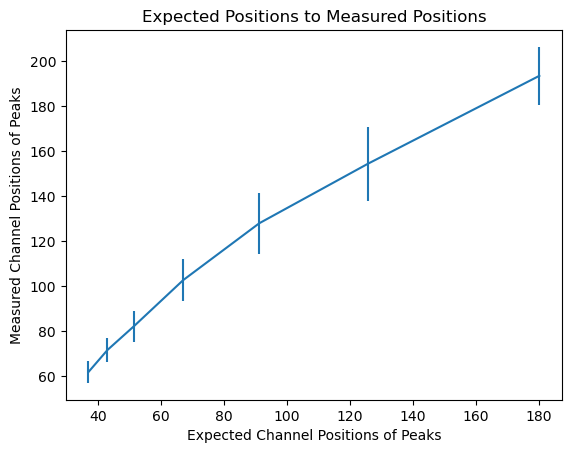

In [9]:
expected_channel = angle_expected_channel(channel, energy, angle)

plt.errorbar(expected_channel, channel, yerr = delta_peaks2/2)
plt.ylabel('Measured Channel Positions of Peaks')
plt.xlabel('Expected Channel Positions of Peaks')
plt.title('Expected Positions to Measured Positions')

In [10]:
def channel_to_energy(channel):
    energy = channel*calibration_slope+calibration_intercept
    return energy

def widths_to_energy(widths):
    delta_energy = widths*calibration_slope
    return delta_energy

print('  Channel | Energy (MeV) ')
print('----------|--------------')
for c in channel:
    calibration_energy = channel_to_energy(c)
    print(f' {c:6} | {calibration_energy:15.3f}')
    
print('  FWHM | Delta Energy (MeV) ')
print('-------|--------------')
for f in delta_peaks2:
    delta_energy = widths_to_energy(f)
    print(f' {f:6} | {delta_energy:15.3f}')


energy = channel_to_energy(channel)
delta_e = widths_to_energy(delta_peaks2)

  Channel | Energy (MeV) 
----------|--------------
 193.61 |           0.631
  154.5 |           0.503
 128.04 |           0.416
 102.74 |           0.334
  82.12 |           0.266
   71.7 |           0.232
   61.9 |           0.200
  FWHM | Delta Energy (MeV) 
-------|--------------
  25.69 |           0.084
  32.73 |           0.107
   27.3 |           0.089
   18.8 |           0.061
   13.7 |           0.045
   10.6 |           0.035
    9.7 |           0.032


[[Model]]
    Model(compton_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 7
    # variables        = 1
    chi-square         = 0.08496600
    reduced chi-square = 0.01416100
    Akaike info crit   = -28.8798999
    Bayesian info crit = -28.9339898
    R-squared          = 0.99677612
[[Variables]]
    e:  0.68323421 +/- 0.00857366 (1.25%) (init = 1)


Text(0.5, 1.0, 'Model to Fit our Data to Compton Scattering')

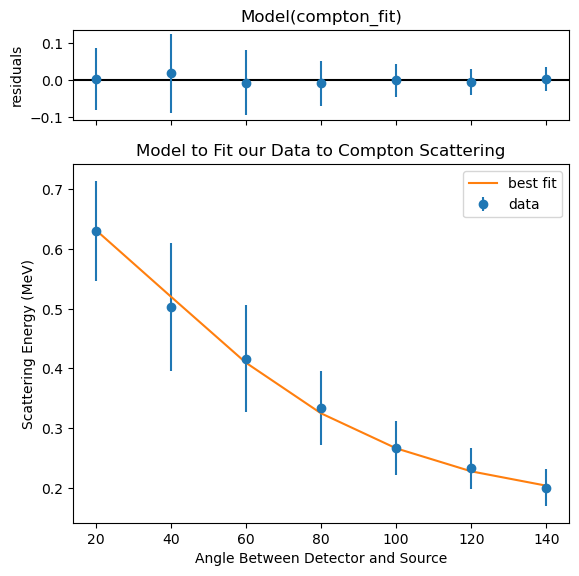

In [11]:
import lmfit

from scipy.constants import c, electron_mass
unit_conversion = 6.242e12

def compton_fit(a, e):
    alpha = (e)/(electron_mass*c**2*unit_conversion)
    expected_energy = e/(1+(alpha)*(1-np.cos(angle*np.pi/180)))
    return expected_energy
    

model = lmfit.Model(compton_fit)
param_guess = model.make_params(e=1)
line_fit = model.fit(energy, param_guess, a=angle, weights=1 / delta_e)
print(line_fit.fit_report())
line_fit.plot()
plt.xlabel('Angle Between Detector and Source')
plt.ylabel('Scattering Energy (MeV)')
plt.title('Model to Fit our Data to Compton Scattering')

In [12]:
print('\ngamma energy = ',line_fit.params['e'].value,'+/-',line_fit.params['e'].stderr)



gamma energy =  0.6832342083315008 +/- 0.00857365623955354


2.0794415416798357


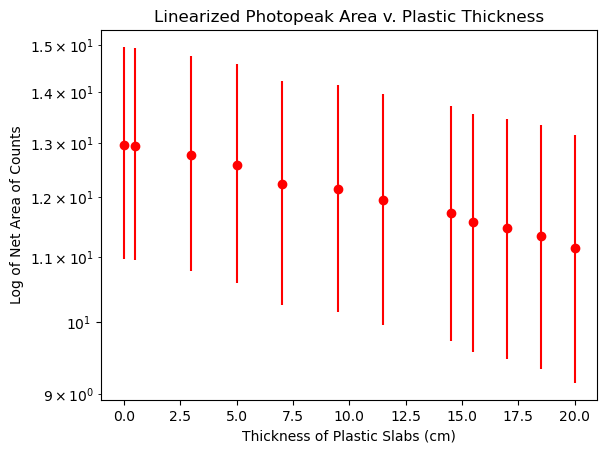

In [23]:
log_counts = np.log(counts)
error = np.full_like(counts, 2)
print(np.log(8))
plt.errorbar(thickness, log_counts, yerr=2, fmt='ro')
plt.yscale('log')
plt.xlabel('Thickness of Plastic Slabs (cm)')
plt.ylabel('Log of Net Area of Counts')
plt.title('Linearized Photopeak Area v. Plastic Thickness')
plt.show()

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 114
    # data points      = 12
    # variables        = 2
    chi-square         = 20763723.8
    reduced chi-square = 2076372.38
    Akaike info crit   = 176.365736
    Bayesian info crit = 177.335549
    R-squared          = 0.99293560
[[Variables]]
    A:  437251.914 +/- 7520.09339 (1.72%) (init = 1)
    B: -0.08987255 +/- 0.00291900 (3.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B) = -0.6100


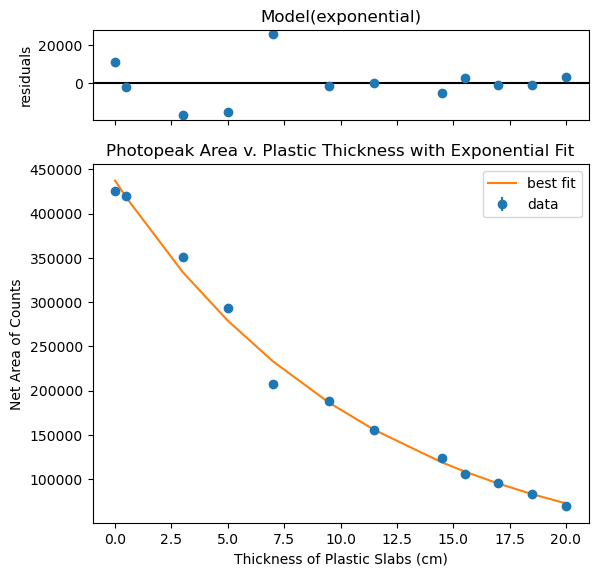

In [43]:
def exponential(x,A,B):
    return A*np.exp(B*x)
model = lmfit.Model(exponential)
param_guess = model.make_params(A=1, B=1)
line_fit = model.fit(counts, param_guess, x=thickness, weights=1/8)
print(line_fit.fit_report())
line_fit.plot()
plt.xlabel('Thickness of Plastic Slabs (cm)')
plt.ylabel('Net Area of Counts')
plt.title('Photopeak Area v. Plastic Thickness with Exponential Fit')
plt.show()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 12
    # variables        = 2
    chi-square         = 0.09586819
    reduced chi-square = 0.00958682
    Akaike info crit   = -53.9562519
    Bayesian info crit = -52.9864386
    R-squared          = 0.99467881
[[Variables]]
    slope:     -0.09048666 +/- 0.00209290 (2.31%) (init = -0.09048666)
    intercept:  12.9906860 +/- 0.02554347 (0.20%) (init = 12.99069)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8330


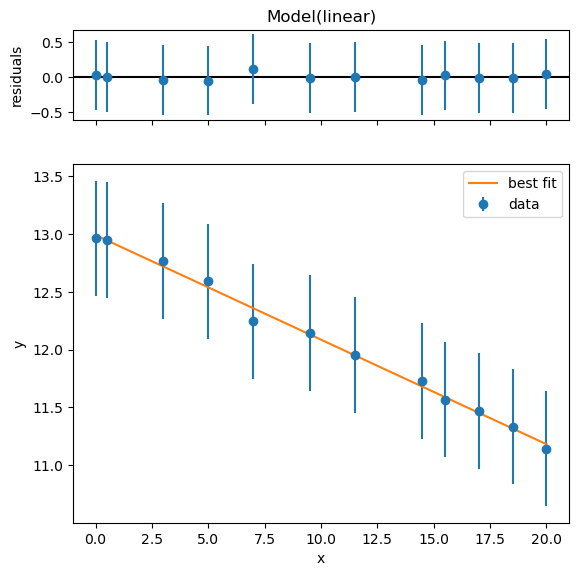

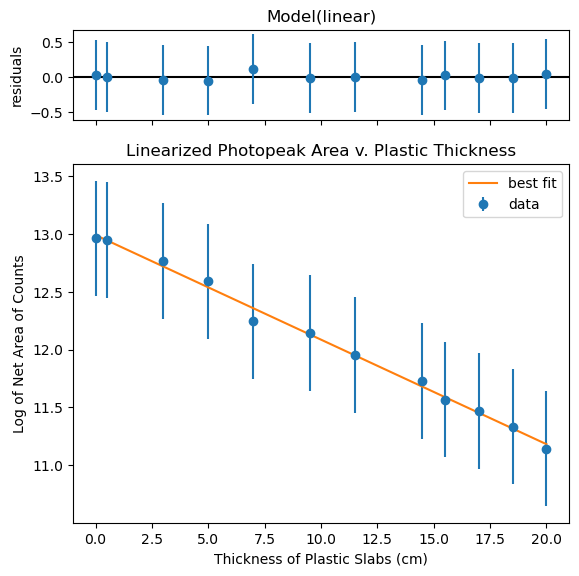

In [44]:
line = LinearModel()
param_guess = line.guess(log_counts, x=thickness)
line_fit = line.fit(log_counts, param_guess, x=thickness, weights=2)
print(line_fit.fit_report())
line_fit.plot();
line_fit.plot()
plt.xlabel('Thickness of Plastic Slabs (cm)')
plt.ylabel('Log of Net Area of Counts')
plt.title('Linearized Photopeak Area v. Plastic Thickness')
plt.show()

In [32]:
print('\nmu = ',np.abs(line_fit.params['slope'].value),'+/-',line_fit.params['slope'].stderr, 'cm^-1')

from uncertainties import ufloat

mu = ufloat(0.09, 0.002)
sigma_c = mu/3.83e23
print("sigma_c:", sigma_c, "cm^2")

gamma = (0.662)/(electron_mass*c**2*unit_conversion)
r = 2.817e-13

def klein_nishina(gamma, r):
    one = (1+gamma)/(gamma**2)
    two = (2*(1+gamma))/(1+2*gamma)
    three = (1/gamma)*np.log(1+2*gamma)
    four = (1/(2*gamma))*np.log(1+2*gamma)
    five = (1+3*gamma)/((1+2*gamma)**2)
    six = 2*np.pi*r**2*(one*(two-three)+four-five)
    return six

print("theory:", klein_nishina(gamma, r), "cm^2")
    
    


mu =  0.09048666303978532 +/- 0.0020928950999780497 cm^-1
sigma_c: (2.35+/-0.05)e-25 cm^2
theory: 2.5597841905815623e-25 cm^2
